# Movie Review Sentiment Analysis Using USE (Universal Sentence Encoder)

**Dataset**

IMDB dataset has 50K movie reviews for natural language processing.
Please download the dataset from [Kaggle link for IMDB master](https://www.kaggle.com/uttam94/imdb-mastercsv) and preprocess the data. Use the column "type" to seperate training and test datasets if needed as used in this case.

**Problem**

A review in the IMDB dataset is either positive or negative. Therefore, the NLP movie review sentiment analysis task is a supervised learning binary classification problem.

**Settings**

1. Split IMDB training data to 20K and 5K.
2. Use 20K in training a model.
3. Get predictions on 5K train data (model_4_5ktrain.csv) and 25K test data (model_4_25ktest.csv).
4. Two prediction files created in Item 3 are used in SSNet combiner.

In [1]:
# Enable intellisense
%config IPCompleter.greedy=True

In [2]:
# Import modules
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt


## from ssnet
from keras.layers import BatchNormalization, InputLayer, RepeatVector
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Flatten

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
pd.set_option('display.max_colwidth',1000)

import importlib

TensorFlow Version: 2.2.0
Hub version:  0.9.0
GPU is available


In [3]:
import sys
sys.path.append("./helpers")
import imdb_preprocess_functions as imdb
dir(imdb)
sys.path.append("../model_helpers")
import model_utils as model_utils

## USE functions
sys.path.append("../use_helpers")
import use_functions as iUse

## Data preprocessing

In [4]:
# Load imdb master data, return 25K train and 25K test datasets
[df_train, df_test] = imdb.get_imdb_df_data('./data/imdb_master.csv')

The number of rows and columns in the training dataset is: (25000, 5)
Missing values in train dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check train class balance
1.0    12500
0.0    12500
Name: label, dtype: int64
The number of rows and columns in the test dataset is: (25000, 5)
Missing values in test dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check test class balance
1.0    12500
0.0    12500
Name: label, dtype: int64


In [5]:
# Preprocess 25K train data. Return review texts with label (positive or negative). Train data is reproducibly shuffled.
train_data = text_train, label_train, df_fit_train = imdb.get_fit_data(df_train, True)

In [6]:
# Specify split size. Use this number in training the model
SPLIT_TRAIN_SIZE = 20000

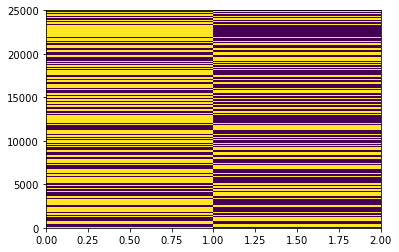

In [7]:
# Plot class districution. Verify it's balanced.
plt.pcolormesh(train_data[1])

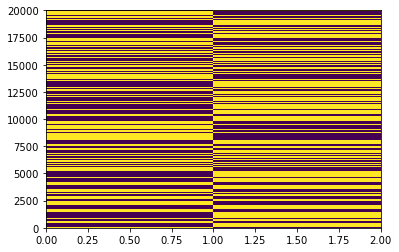

In [8]:
# split train data run
train_final_data = train_data[0][:SPLIT_TRAIN_SIZE], train_data[1][:SPLIT_TRAIN_SIZE], train_data[2][:SPLIT_TRAIN_SIZE]

x_train = train_final_data[0]
y_train = train_final_data[1]
plt.pcolormesh(y_train)

## Model training

In [9]:
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = iUse.get_model(use_model_url, 2, 1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
use_hub_layer (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
predictions (Dense)          (None, 2)                 34        
Total params: 256,806,066
Trainable params: 256,806,066
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model parameter set
BATCH_SIZE = 100
EPOCHS = 7
LRATE = 2e-4
LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

In [11]:
# Specify model name
root_name = 'model_use'
model_file_name = root_name + '_' + str(SPLIT_TRAIN_SIZE) + '_'
model_name = model_file_name + 'epoch_' + str(EPOCHS) + ".h5"

In [12]:
# Train the model

#Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=LRATE)
model.compile(optimizer=opt, 
              loss=LOSS,
              metrics=[METRICS])

Epoch 1/7
200/200 [==============================] - 30s 149ms/step - loss: 0.4865 - accuracy: 0.7970
Epoch 2/7
200/200 [==============================] - 30s 148ms/step - loss: 0.2233 - accuracy: 0.9201
Epoch 3/7
200/200 [==============================] - 30s 149ms/step - loss: 0.0769 - accuracy: 0.9804
Epoch 4/7
200/200 [==============================] - 27s 135ms/step - loss: 0.0240 - accuracy: 0.9959
Epoch 5/7
200/200 [==============================] - 26s 131ms/step - loss: 0.0107 - accuracy: 0.9987
Epoch 6/7
200/200 [==============================] - 27s 135ms/step - loss: 0.0051 - accuracy: 0.9995
Epoch 7/7
200/200 [==============================] - 27s 137ms/step - loss: 0.0025 - accuracy: 0.9998
dict_keys(['loss', 'accuracy'])


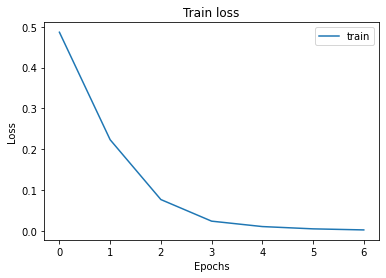

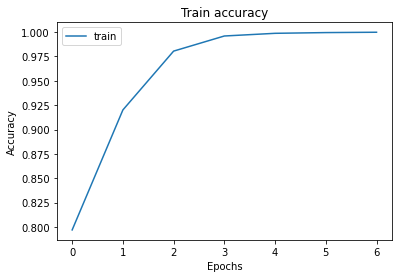

In [13]:
# Fit the data to the model
history = model.fit(x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
                    verbose = 1)

# Save the trained model
model.save(model_name)
model_utils.get_history(history)

In [14]:
# Load the pretrained nlp_model
from tensorflow.keras.models import load_model
new_model = load_model(model_name, custom_objects={'KerasLayer':hub.KerasLayer})

In [16]:
test_data = text_test, label_test, df_fit_test = imdb.get_fit_data(df_test, False)
# Use 5K split train data as test data to get predictions
test_final_data = train_data[0][SPLIT_TRAIN_SIZE:], train_data[1][SPLIT_TRAIN_SIZE:], train_data[2][SPLIT_TRAIN_SIZE:]

x_test = test_final_data[0]
y_test = test_final_data[1]

In [17]:
# Get predictions for test data
prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, BATCH_SIZE)

50/50 [==============================] - 5s 98ms/step - loss: 0.3746 - accuracy: 0.8930
[0.3745574653148651, 0.8930000066757202]
              precision    recall  f1-score   support

           0     0.8897    0.8965    0.8931      2492
           1     0.8963    0.8896    0.8929      2508

    accuracy                         0.8930      5000
   macro avg     0.8930    0.8930    0.8930      5000
weighted avg     0.8930    0.8930    0.8930      5000



In [18]:
# Create result file
result_file_root_name = root_name + '_result'
run_type = 2 #split run
model_utils.output_result(test_final_data[2], result_file_root_name, run_type, prediction_prob, SPLIT_TRAIN_SIZE)

196/196 [==============================] - 24s 124ms/step - loss: 0.3913 - accuracy: 0.8850
[0.39127081632614136, 0.8849999904632568]
              precision    recall  f1-score   support

           0     0.8775    0.8950    0.8861     12500
           1     0.8928    0.8750    0.8838     12500

    accuracy                         0.8850     25000
   macro avg     0.8852    0.8850    0.8850     25000
weighted avg     0.8852    0.8850    0.8850     25000



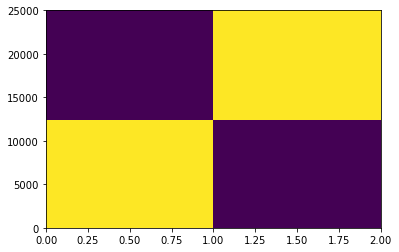

In [20]:
# Run prediction and create result file for 25k test data for split run
x_test = test_data[0]
y_test = test_data[1]
plt.pcolormesh(y_test)
prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, 128)
model_utils.output_result(test_data[2], result_file_root_name, run_type, prediction_prob, SPLIT_TRAIN_SIZE)

In [21]:
# Rename files for SSNet combiners
import os
os.rename(r'model_use_result_split_25000_20000.csv',r'model_4_25ktest.csv')
os.rename(r'model_use_result_split_5000_20000.csv',r'model_4_5ktrain.csv')